In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import sys
sys.path.append('../')
sys.path.append('../../')

from common import *
from env import *


class NormalDist:
    def __init__(self, loc=0, scale=1) -> None:
        self.loc = loc
        self.scale = scale
    
    def __call__(self):
        return np.random.normal(loc=self.loc, scale=self.scale)


# The next two functions are common code that make all the trajectory plots. Updating
# them here will update them everywhere
def plot_traj_and_qr(traj, qr, eps, N, n_step=1, ax=None, save_path=None):
    if type(ax) == type(None):
        plt.clf()
        plt.gcf().set_size_inches(8, 3)
        ax = plt.gca()

    sig = None
    if type(eps) is NormalDist:
        sig = eps.scale
        eps = eps.loc

    qr = np.array(qr)
    qr = np.flip(qr.T, axis=0) + eps
    im = ax.imshow(qr, aspect='auto', vmin=0, vmax=10)

    ticks = np.arange(N) * n_step
    ax.set_yticks(ticks, np.flip(np.arange(N) + 1))
    ax.set_ylabel('N')
    ax.set_xlabel('Steps')
    sig_str = fr',\; \sigma = {sig}'
    ax.set_title(fr'$\epsilon = {eps} {sig and sig_str}$')

    plt.colorbar(im, ax=ax)

    adj = -0.425 if n_step == 1 else 2.75
    ax.plot(10 * n_step - np.array(traj)[1:] + adj, color='red')
    ax.set_xlim((0, len(traj) - 1.5))

    plt.gcf().tight_layout()

    if save_path:
        plt.savefig(save_path)
        

def plot_traj_slices(qr, eps, ax=None, n_steps=1):
    if ax == None:
        ax = plt.gca()
        
    if type(eps) is NormalDist:
        eps = eps.loc

    qr = np.array(qr) + eps

    cmap = mpl.colormaps['plasma']

    for i in [0, 2, 4, 7, 9]:
        ax.plot(qr[:,i*n_steps + n_steps - 1], label=f'N = {i+1}', color=cmap(i/13), alpha=0.6)

    ax.set_xlabel('Step')
    ax.set_ylabel(r'Q value')
    ax.legend()

In [2]:
fig_dir = Path('fig')   # directory that will contained saved figures
if not fig_dir.exists():
    fig_dir.mkdir()

# Incremental

In [3]:
eps = np.linspace(-5, 4, num=25)
N = 10

all_lens = []

n_iters = 5

for _ in range(n_iters):
    trajs = [run_exp_inc(eps=e, goal_length=N) for e in eps]
    traj_lens = [len(t) for t, _ in trajs]
    all_lens.append(traj_lens)

all_lens = np.array(all_lens)

Text(0, 0.5, 'Steps')

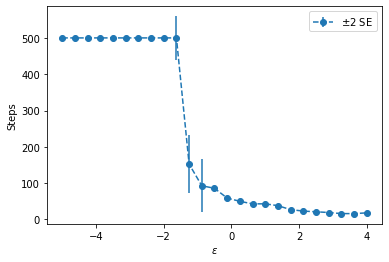

In [4]:
mean = np.mean(all_lens, axis=0)
sd_err = np.std(all_lens, axis=0) / np.sqrt(n_iters)

plt.errorbar(eps, traj_lens, fmt='o--', yerr=sd_err, label=r'$\pm 2$ SE')
plt.legend()

plt.xlabel(r'$\epsilon$')
plt.ylabel('Steps')

# plt.savefig('fig/fig2_inc_failure.png')

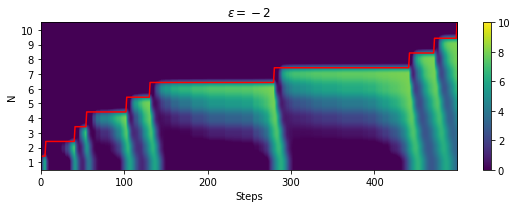

In [5]:
N = 10
eps = -2
traj, info = run_exp_inc(eps=eps, goal_length=N)
plot_traj_and_qr(traj, info['qr'], eps, N, save_path='fig/fig2_failure_qr.png')

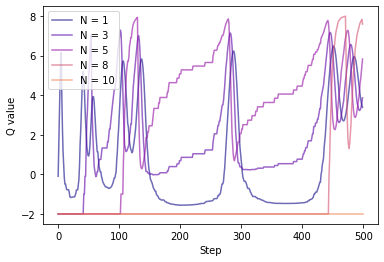

In [6]:
plot_traj_slices(info['qr'], eps)

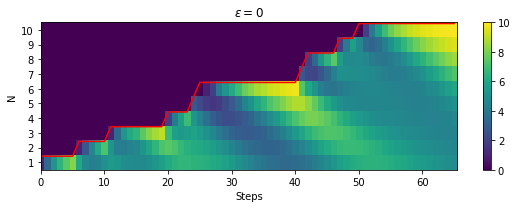

In [7]:
N = 10
eps = 0
traj, info = run_exp_inc(eps=eps, goal_length=N)
plot_traj_and_qr(traj, info['qr'], eps, N, save_path='fig/fig2_middling_qr.png')

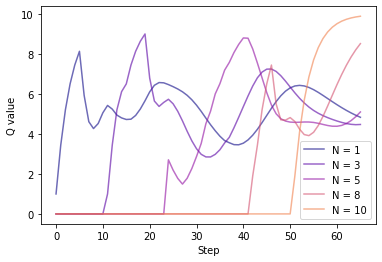

In [8]:
plot_traj_slices(info['qr'], eps)

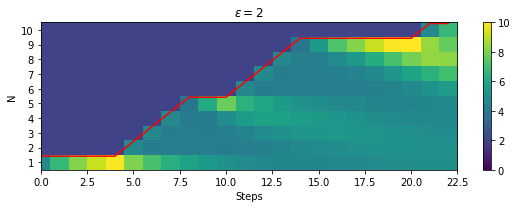

In [9]:
N = 10
eps = 2
traj, info = run_exp_inc(eps=eps, goal_length=N)
plot_traj_and_qr(traj, info['qr'], eps, N, save_path='fig/fig2_success_qr.png')

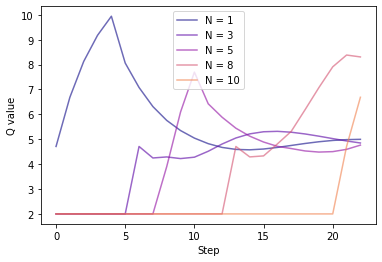

In [10]:
plot_traj_slices(info['qr'], eps)

# POMCP

Download dataframe file (`pomcp.pkl`) on the Google drive: https://drive.google.com/drive/u/1/folders/1yQ0WoPIlG-XdAXXAZLD5-Qz-3NpMtTXg

In [11]:
df = pd.read_pickle('pomcp.pkl')

Individual rows can be plotted much in the same way as above. Below is an example of three different runs:

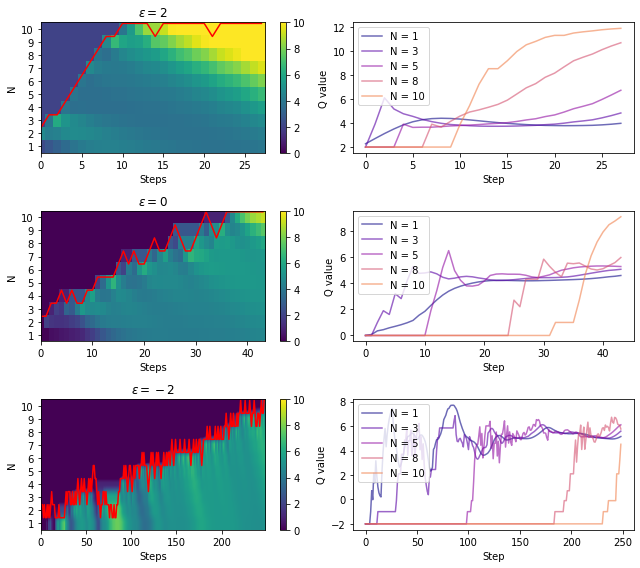

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(9, 8), sharey=False)

N = 10
eps = 2
row = df.loc[14]
traj, info = row['runs'][0], row['info'][0]
plot_traj_and_qr(traj, info['qr'], eps, N, ax=axs[0][0])
plot_traj_slices(info['qr'], ax=axs[0][1], eps=eps)

N = 10
eps = 0
row = df.loc[12]
traj, info = row['runs'][0], row['info'][0]
plot_traj_and_qr(traj, info['qr'], eps, N, ax=axs[1][0])
plot_traj_slices(info['qr'], ax=axs[1,1], eps=eps)

N = 10
eps = -2
row = df.loc[10]
traj, info = row['runs'][0], row['info'][0]
plot_traj_and_qr(traj, info['qr'], eps, N, ax=axs[2,0])
plot_traj_slices(info['qr'], ax=axs[2,1], eps=eps)

fig.tight_layout()

plt.savefig('fig/pomcp_conjoined.png')

# Adaptive

Individual plots can be made much in the same way as before. Below I plot three different examples assembled into a single image.

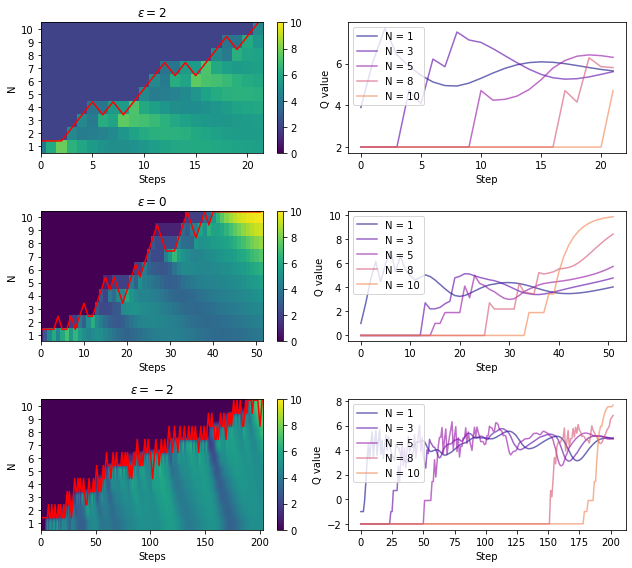

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(9, 8))

N = 10
eps = [2, 0, -2]

for e, ax in zip(eps, axs):
    traj, info = run_adp_exp_disc(eps=e, goal_length=N)
    plot_traj_and_qr(traj, info['qr'], e, N, ax=ax[0])
    plot_traj_slices(info['qr'], e, ax=ax[1])

plt.savefig('fig/adp_conjoined.png')

# Benchmarks

In [14]:
n_iters = 10
Ns = [3, 5, 10]
eps = np.linspace(-2, 2, num=5)
# max_steps = 500

T = 3
lr = 0.1
alpha = 0.1
beta = 1
k = 5

raw_data = []

for N in tqdm(Ns):
    for e in eps:
        cases = [
            Case('Adaptive', run_adp_exp_disc, {'eps': e, 'goal_length': N}, []),
            Case('Incremental', run_exp_inc, {'eps': e, 'goal_length': N}, []),
            Case('Online', run_online, {'eps': e, 'goal_length': N, 'alpha': alpha, 'beta': beta}, []),
            Case('Naive', run_naive, {'eps': e, 'goal_length': N, 'alpha': alpha, 'beta': beta, 'k': k}, []),
            Case('Window', run_window, {'eps': e, 'goal_length': N, 'alpha': alpha, 'beta': beta, 'k': k}, []),
            Case('Sampling', run_sampling, {'eps': e, 'goal_length': N, 'alpha': alpha, 'k': k}, []),
            Case('Random', run_random, {'eps': e, 'goal_length': N}, []),
            Case('Final', run_final_task_only, {'eps': e, 'goal_length': N}, []),
        ]

        run_exp(n_iters=n_iters, cases=cases, max_steps=N * 100, lr=lr, T=T)
        raw_data.extend(cases)

df_bench = pd.DataFrame(raw_data)
df = pd.concat((df, df_bench), ignore_index=True)

  0%|                                                     | 0/3 [00:00<?, ?it/s]/home/grandpaa/workspace/trails/venv_trail/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/grandpaa/workspace/trails/venv_trail/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/grandpaa/workspace/trails/venv_trail/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
100%|█████████████████████████████████████████████| 3/3 [00:31<00:00, 10.50s/it]


In [15]:
# setting up for benchmark plotting
fig_dir = Path('fig/us_v_matiisen_v_pomcp')
if not fig_dir.exists():
    fig_dir.mkdir(parents=True)

def extract_plot_vals(row):
    traj_lens = [len(traj) for traj in row['runs']]

    return pd.Series([
        row['name'],
        row['run_params']['goal_length'],
        np.round(row['run_params']['eps'], decimals=2),
        traj_lens
    ], index=['name', 'N', 'eps', 'traj_lens'])

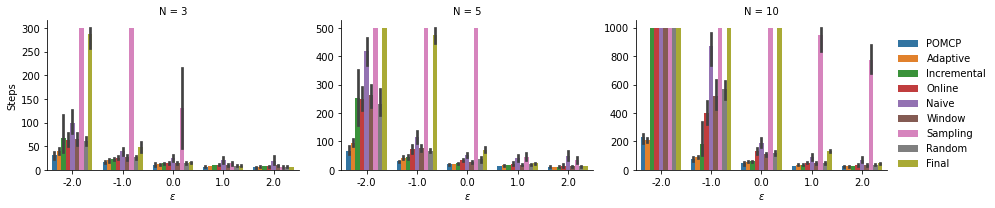

In [16]:
plot_df = df.apply(extract_plot_vals, axis=1).explode('traj_lens')

g = sns.catplot(plot_df, x='eps', y='traj_lens', hue='name', col='N', kind='bar', sharey=False, height=3, aspect=1.4)
g.set_axis_labels(f'$\epsilon$', 'Steps')
g.legend.set_title('')

plt.savefig('fig/us_v_matiisen_v_pomcp/seq_benchmarks_conjoined.png')

# Continuous curricula

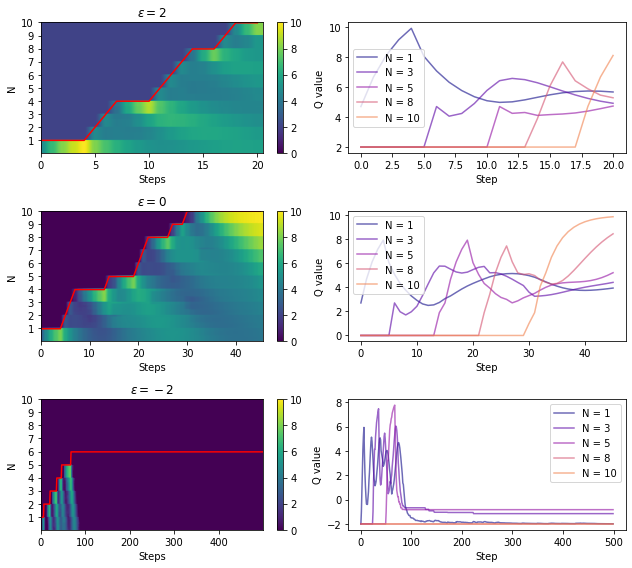

In [17]:
### Incremental
fig, axs = plt.subplots(3, 2, figsize=(9, 8))

N = 10
eps_s = [2, 0, -2]

for i, eps in enumerate(eps_s):
    traj, info = run_inc_cont(eps=eps, goal_length=N)
    plot_traj_and_qr(traj, info['qr'], eps, N, ax=axs[i,0], n_step=100)
    plot_traj_slices(info['qr'], eps, n_steps=100, ax=axs[i,1],)

plt.savefig('fig/inc_cont_conjoined.png')

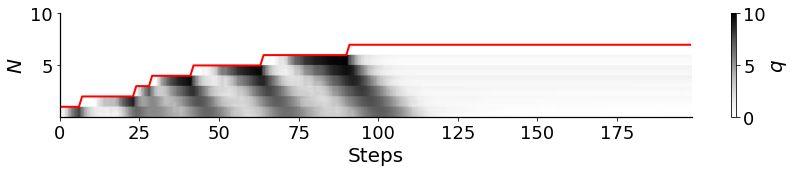

In [60]:
def plot_traj_and_qr_spec(traj, qr, eps, N, n_step=1, ax=None, save_path=None):
    if type(ax) == type(None):
        plt.clf()
        plt.gcf().set_size_inches(8, 3)
        ax = plt.gca()

    fig = plt.gcf()
    fig.set_size_inches((12, 2.5))
    qr = np.array(qr)
    qr = np.flip(qr.T, axis=0)
    im = ax.imshow(qr, aspect='auto', vmin=0, vmax=10, cmap='Greys')

    ticks = np.array([0, 5, 10]) * n_step
    ax.set_yticks(ticks, np.flip(np.array((0, 5, 10))))
    # ax.set_title('Incremental', fontsize=20)

    adj = -0.425 if n_step == 1 else 2.75
    ax.plot(10 * n_step - np.array(traj)[1:] + adj, color='red', lw=2)
    ax.set_xlim((0, len(traj) - 1.5))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.25)
    ax.spines['left'].set_linewidth(1.25)
    ax.tick_params(labelsize = 18)
    ax.set_ylabel(r"$N$", fontsize = 20)
    ax.set_xlabel(r"Steps", fontsize = 20)

    cb = fig.colorbar(mappable = im)
    cb.ax.tick_params(labelsize=18)
    cb.set_ticks([0,5,10])
    cb.set_label("$q$", fontsize = 20)

    fig.tight_layout()

    if save_path:
        plt.savefig(save_path)

np.random.seed(4)

N = 10
eps_s = [-2]

for i, eps in enumerate(eps_s):
    traj, info = run_inc_cont(eps=eps, goal_length=N)

    traj = traj[:200]
    qrs = np.array(info['qr'])[:200,:]
    plot_traj_and_qr_spec(traj, qrs, eps, N, n_step=100)
    plt.savefig('fig/incremental_qs.svg')
    plt.show()


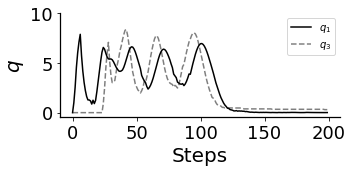

In [58]:
def plot_traj_slices(qr, eps, n_steps=1):
    qr = np.array(qr) + eps

    # cmap = mpl.colormaps['plasma']

    # for i in [0, 2, 4, 7, 9]:
    #     ax.plot(qr[:,i*n_steps + n_steps - 1], label=f'N = {i+1}', color=cmap(i/13), alpha=0.6)

    fig,ax = plt.subplots(1,1,figsize = (5,2.5))
    ax.plot(qr[:,0],'k-',lw=1.5,label = r"$q_1$")
    ax.plot(qr[:,200],'k--',lw = 1.5,alpha = 0.5,label = r"$q_3$")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.25)
    ax.spines['left'].set_linewidth(1.25)
    ax.tick_params(labelsize = 18)
    ax.set_yticks([0,5,10])
    # ax.set_xlim(0,120)
    # ax.set_xticks([0,40,80,120])
    ax.set_ylabel(r"$q$", fontsize = 20)
    ax.set_xlabel(r"Steps", fontsize = 20)
    fig.tight_layout()
    ax.legend()

np.random.seed(4)
N = 10
epss = [-2]
for ie,eps in enumerate(epss):
    traj, info = run_inc_cont(eps=eps, goal_length=N)
    qrs = np.array(info['qr'])[:200] - eps

    plot_traj_slices(qrs, eps)

    plt.savefig('fig/inc_traj_slice.svg')
    plt.show()


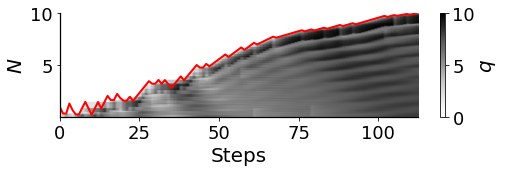

In [62]:
# def plot_traj_and_qr_spec(traj, qr, eps, N, n_step=1, ax=None, save_path=None):
#     if type(ax) == type(None):
#         plt.clf()
#         plt.gcf().set_size_inches(8, 3)
#         ax = plt.gca()

#     fig = plt.gcf()
#     fig.set_size_inches((12, 2.5))
#     qr = np.array(qr)
#     qr = np.flip(qr.T, axis=0) + eps
#     im = ax.imshow(qr, aspect='auto', vmin=0, vmax=10, cmap='Greys')

#     ticks = np.array([0, 5, 10]) * n_step
#     ax.set_yticks(ticks, np.flip(np.array((0, 5, 10))))
#     # ax.set_title('Incremental', fontsize=20)

#     adj = -0.425 if n_step == 1 else 2.75
#     ax.plot(10 * n_step - np.array(traj)[1:] + adj, color='red', lw=2)
#     ax.set_xlim((0, len(traj) - 1.5))

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_linewidth(1.25)
#     ax.spines['left'].set_linewidth(1.25)
#     ax.tick_params(labelsize = 18)
#     ax.set_ylabel(r"$N$", fontsize = 20)
#     ax.set_xlabel(r"Steps", fontsize = 20)

#     cb = fig.colorbar(mappable = im)
#     cb.ax.tick_params(labelsize=18)
#     cb.set_ticks([0,5,10])
#     cb.set_label("$q$", fontsize = 20)

#     fig.tight_layout()

#     if save_path:
#         plt.savefig(save_path)

np.random.seed(6)

N = 10
eps_s = [-2]

for i, eps in enumerate(eps_s):
    traj, info = run_exp_cont(eps=eps, goal_length=N)

    # traj = traj[:200]
    # qrs = np.array(info['qr'])[:200,:]
    plot_traj_and_qr_spec(traj, info['qr'], eps, N, n_step=100)
    # plt.savefig('fig/incremental_qs.svg')
    plt.gcf().set_size_inches(6.8, 2.5)
    plt.gca().set_xticks([0, 25, 50, 75, 100])
    plt.savefig('fig/adp_qs.svg')
    plt.show()

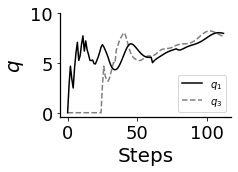

In [65]:
np.random.seed(6)
N = 10
epss = [-2]
for ie,eps in enumerate(epss):
    traj, info = run_exp_cont(eps=eps, goal_length=N)

    qr = np.array(info['qr']) - eps
    plot_traj_slices(qr, eps)

    plt.gcf().set_size_inches(3, 2.5)
    plt.savefig('fig/adp_traj_slice.svg')
    plt.show()

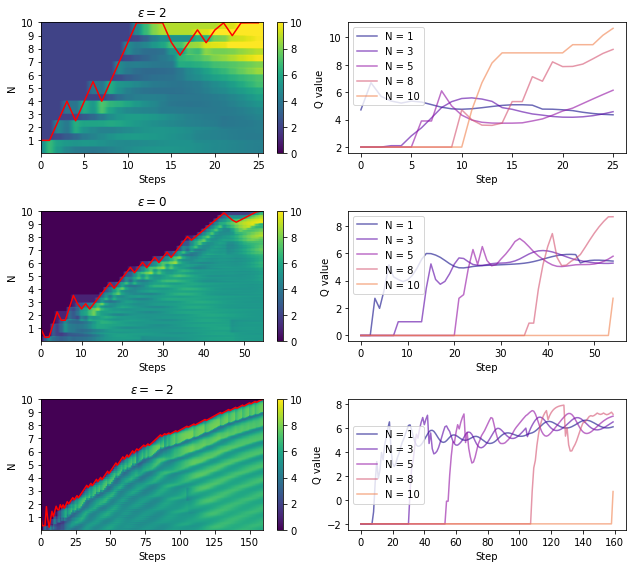

In [18]:
### Adaptive
fig, axs = plt.subplots(3, 2, figsize=(9, 8))

N = 10
eps_s = [2, 0, -2]

for i, eps in enumerate(eps_s):
    traj, info = run_exp_cont(eps=eps, goal_length=N)
    plot_traj_and_qr(traj, info['qr'], eps, N, ax=axs[i,0], n_step=100)
    plot_traj_slices(info['qr'], eps, n_steps=100, ax=axs[i,1])

plt.savefig('fig/exp_cont_conjoined.png')

In [2]:
### Benchmarks
n_iters = 5
Ns = [10]
eps = np.linspace(-3, 2, num=6)
# max_steps = 500

T = 3
lr = 0.1
alpha = 0.1
beta = 1
k = 5

raw_data = []

for N in tqdm(Ns):
    for e in eps:
        cases = [
            Case('ADP', run_exp_cont, {'eps': e, 'goal_length': N}, []),
            Case('INC', run_inc_cont, {'eps': e, 'goal_length': N}, []),
            
            # Random and Final do not work on continuous curricula, and so are commented out
            # ---
            # Case('Random', run_random, {'eps': e, 'goal_length': N, 'is_cont': True}, []),
            # Case('Final', run_final_task_only, {'eps': e, 'goal_length': N, 'is_cont': True}, []),
        ]

        run_exp(n_iters=n_iters, cases=cases, max_steps=N * 100, lr=lr, T=T)
        raw_data.extend(cases)

df = pd.DataFrame(raw_data)

100%|██████████| 1/1 [01:20<00:00, 80.35s/it]


In [3]:
# Setting up for benchmarks plotting
fig_dir = Path('fig/benchmark_cont')
if not fig_dir.exists():
    fig_dir.mkdir(parents=True)

def extract_plot_vals(row):
    traj_lens = [len(traj) for traj in row['runs']]

    return pd.Series([
        row['name'],
        row['run_params']['goal_length'],
        np.round(row['run_params']['eps'], decimals=2),
        traj_lens
    ], index=['name', 'N', 'eps', 'traj_lens'])

In [4]:
plot_df = df.apply(extract_plot_vals, axis=1).explode('traj_lens')

/tmp/ipykernel_27977/1103777625.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels([-3, -2, -1, 0, 1, 2])


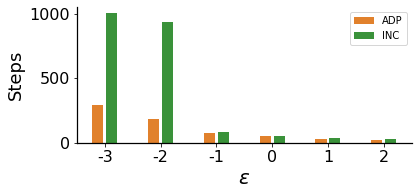

In [36]:
plt.gcf().set_size_inches(6, 2.5)

g = sns.barplot(plot_df, x='eps', y='traj_lens', hue='name', palette=['C1', 'C2'], errorbar=None, width=0.5, gap=0.2)
g.set_xlabel(r'$\varepsilon$', fontsize=20)
g.set_ylabel('Steps', fontsize=18)
g.tick_params(labelsize=16)
g.set_yticks([0, 500, 1000])
g.set_xticklabels([-3, -2, -1, 0, 1, 2])
g.legend().set_title('')

g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
g.spines['bottom'].set_linewidth(1.25)
g.spines['left'].set_linewidth(1.25)

plt.savefig('fig/cont_bench.svg')

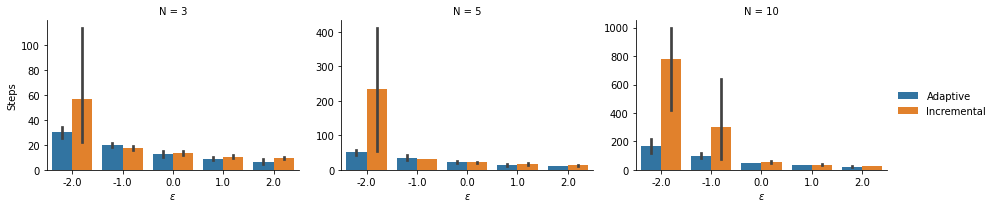

In [21]:
# plot_df = df.apply(extract_plot_vals, axis=1).explode('traj_lens')

# g = sns.catplot(plot_df, x='eps', y='traj_lens', hue='name', col='N', kind='bar', sharey=False, height=3, aspect=1.4)
# g.set_axis_labels(f'$\epsilon$', 'Steps')
# g.legend.set_title('')

plt.savefig(fig_dir / 'cont_benchmarks_conjoined.png')plt.close("all")
fig,axis = plt.subplots(1,1,figsize = (10,2.5))

colors = ["C%d"%(i+1) for i in range(8)]
for i in range(6):
    axis.bar(np.linspace(-0.3,0.3,8)+ epss[i],data_bench_means[i], width=0.05, color=colors)

axis.bar(epss_pomcp - 0.38, data_pomcp_means, width = 0.05, color = 'C0', label = 'POMCP')
names_plot = ["ADP", "INC", "Online", "Naive", "Window","Sampling", "RAND", "Final"]
for j in range(8):
    axis.bar([1],[0],color = colors[j],label = names_plot[j])
    
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.spines['bottom'].set_linewidth(1.25)
axis.spines['left'].set_linewidth(1.25)
axis.tick_params(labelsize = 16)
axis.legend(bbox_to_anchor=(1.02, 1.025), frameon=False, fontsize = 10)
axis.set_ylabel("Steps",fontsize = 18)
axis.set_xlabel(r"$\varepsilon$",fontsize = 20)
fig.tight_layout()
fig.savefig(prefix + "fig3_seqtask_benchmarks.pdf")
plt.show()

# Heterogeneous epsilon

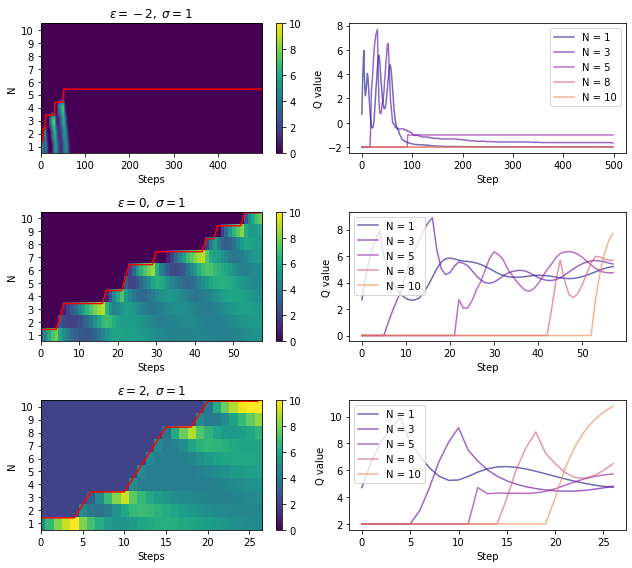

In [30]:
### INCREMENTAL
fig, axs = plt.subplots(3, 2, figsize=(9, 8))

N = 10
eps = [NormalDist(-2, 1), NormalDist(0, 1), NormalDist(2, 1)]

for e, ax in zip(eps, axs):
    traj, info = run_exp_inc(eps=e, goal_length=N)
    plot_traj_and_qr(traj, info['qr'], e, N, ax=ax[0])
    plot_traj_slices(info['qr'], e, ax=ax[1])

plt.savefig('fig/inc_hetero_sig1.png')

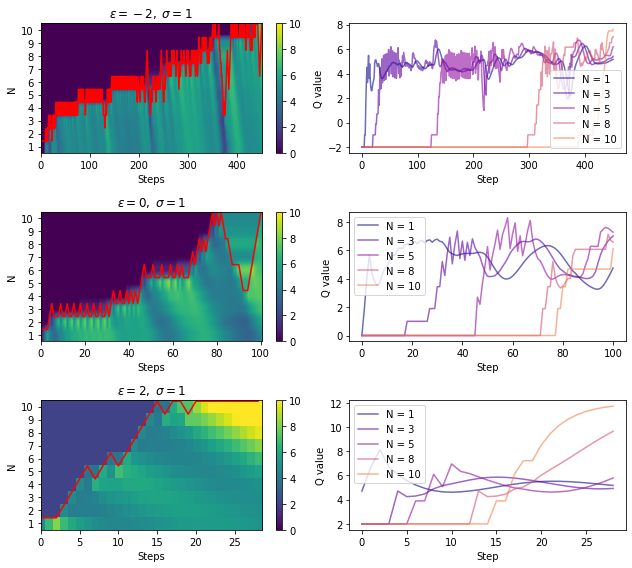

In [35]:
### ADAPTIVE
fig, axs = plt.subplots(3, 2, figsize=(9, 8))

N = 10
eps = [NormalDist(-2, 1), NormalDist(0, 1), NormalDist(2, 1)]

for e, ax in zip(eps, axs):
    traj, info = run_adp_exp_disc(eps=e, goal_length=N)
    plot_traj_and_qr(traj, info['qr'], e, N, ax=ax[0])
    plot_traj_slices(info['qr'], e, ax=ax[1])

plt.savefig('fig/adp_hetero_sig1.png')

In [37]:
# BENCHMARKS
n_iters = 10
Ns = [3, 5, 10]
eps = np.linspace(-2, 2, num=5)
sigs = [0.5, 1, 2, 4]
# max_steps = 500

T = 3
lr = 0.1

raw_data = []

for N in tqdm(Ns):
    for e in eps:
        for s in sigs:
            eps_dist = NormalDist(loc=e, scale=s)
            cases = [
                Case('Adaptive', run_adp_exp_disc, {'eps': eps_dist, 'goal_length': N}, []),
                Case('Incremental', run_exp_inc, {'eps': eps_dist, 'goal_length': N}, []),
                Case('Random', run_random, {'eps': eps_dist, 'goal_length': N}, []),
            ]

            run_exp(n_iters=n_iters, cases=cases, max_steps=N * 100, lr=lr, T=T)
            raw_data.extend(cases)

df = pd.DataFrame(raw_data)

100%|██████████| 3/3 [00:34<00:00, 11.46s/it]


<Figure size 432x288 with 0 Axes>

<Figure size 1002.95x216 with 0 Axes>

<Figure size 1002.95x216 with 0 Axes>

<Figure size 1002.95x216 with 0 Axes>

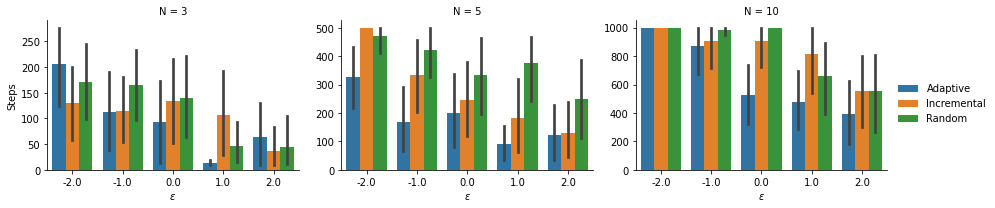

In [45]:
# setting up for benchmark plotting
fig_dir = Path('fig/hetero_eps')
if not fig_dir.exists():
    fig_dir.mkdir(parents=True)

def extract_plot_vals(row):
    traj_lens = [len(traj) for traj in row['runs']]

    return pd.Series([
        row['name'],
        row['run_params']['goal_length'],
        np.round(row['run_params']['eps'].loc, decimals=2),
        np.round(row['run_params']['eps'].scale, decimals=2),
        traj_lens
    ], index=['name', 'N', 'eps', 'sig', 'traj_lens'])


plot_df = df.apply(extract_plot_vals, axis=1).explode('traj_lens')

for s in sigs:
    plt.clf()

    g = sns.catplot(plot_df[plot_df['sig'] == s], x='eps', y='traj_lens', hue='name', col='N', kind='bar', sharey=False, height=3, aspect=1.4)
    g.set_axis_labels(f'$\epsilon$', 'Steps')
    g.legend.set_title('')

    plt.savefig(fig_dir / f'hetero_eps_sig_{s}.png')